In [1]:
import os
import re
import json
import nltk
import requests
import pandas as pd
from bs4 import BeautifulSoup
from typing import Dict, List, Optional, Union, cast

## Plots, Graphs, & Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

## setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

# ------------- #
# Local Imports #
# ------------- #

## importing sys
import sys

## adding 00_helper_files to the system path as First Location to look
sys.path.insert(0, '/Users/qmcbt/codeup-data-science/00_helper_files')
## adding 03_projects Personal Work folder for current project to the system path as Second Location to look
sys.path.insert(1, '/Users/qmcbt/codeup-data-science/03_projects/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project/justin_docs')
## adding 03_projects Root folder for current project to the system path as Third Location to look
sys.path.insert(2, '/Users/qmcbt/codeup-data-science/03_projects/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project')

## env containing sensitive access credentials
import env
from env import github_token, github_username
from env import user, password, host
from env import get_db_url

## Import Helper Modules
import QMCBT_00_quicktips as qt
import QMCBT_01_acquire as acq
import QMCBT_02_prepare as prep
import QMCBT_03_explore as exp
import QMCBT_04_visualize as viz
import QMCBT_05_model as mod
import acquire as ac
import prepare as pr

# Seed 42
# Split 50/30/20

# ACQUIRE

In [2]:
df = pr.get_clean_df()
df.head()

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff,has_#9,has_tab,has_parts,has_fix,has_x,has_v,has_codeblock,has_image,language
0,"<p align=""center""><img src=""https://live.stati...",SpaceX REST API Open Source REST API for lau...,spacex rest api open source rest api launch ro...,spacex rest api open source rest api launch ro...,0.7717,475,7208,6713,0,0,0,0,0,0,0,1,JavaScript
1,\nARCHIVED VERSION OF Space Engineers. This ve...,ARCHIVED VERSION OF Space Engineers. This vers...,archived version engineers version uptodate ve...,archived version engineer version uptodate ver...,0.9633,417,4943,4515,0,0,0,0,0,0,0,0,C#
2,# Spaceship Generator\n\nA Blender script to p...,# Spaceship Generator A Blender script to pro...,spaceship generator blender script procedurall...,spaceship generator blender script procedurall...,0.0000,117,3587,3469,0,0,0,0,0,0,0,0,Python
3,# Spacegray\n\nA set of custom UI themes for S...,# Spacegray A set of custom UI themes for Sub...,spacegray set custom ui themes sublime text hy...,spacegray set custom ui theme sublime text hyp...,0.0000,95,3964,3866,0,0,0,0,0,0,0,0,JavaScript
4,# S P A C E\n\n![cover](resources/space-readme...,# S P A C E ![cover . You can read it here: ...,p c e cover read,p c e cover read,0.0000,16,5705,5689,0,0,0,0,0,0,0,0,JavaScript


In [3]:
df.shape

(432, 17)

In [4]:
df.language.unique()

['JavaScript', 'C#', 'Python', 'Java']
Categories (4, object): ['C#', 'Java', 'JavaScript', 'Python']

In [5]:
# Average Readme Length
#df['lem_length'] = df['lemmatized'].str.len()
Python = df[df.language == 'Python']
JavaScript = df[df.language == 'JavaScript']
C = df[df.language == 'C#']
Java = df[df.language == 'Java']
print('    Python = ' , Python.lem_length.mean())
print('Javascript = ', JavaScript.lem_length.mean()) 
print('        C# =', C.lem_length.mean()) 
print('      Java =', Java.lem_length.mean())

    Python =  488.9124087591241
Javascript =  367.202614379085
        C# = 1072.3118279569892
      Java = 422.2040816326531


# SPLIT

In [6]:
# Split ~50/30/20
train, validate, test = pr.split_data(df, explore=True)

In [7]:
# Check split
train.shape[0]/df.shape[0], validate.shape[0]/df.shape[0], test.shape[0]/df.shape[0]

(0.5578703703703703, 0.24074074074074073, 0.2013888888888889)

In [8]:
# Create word lists by language
def word_groups(df, target):
    """
    DESCRIPTION:
    This function creates DataFrames for each language,
    then creates word groups by breaking the lemmatized and clean columns into word lists by language.
    ___________________________________
    REQUIRED IMPORTS:
    import pandas as pd
    ___________________________________
    ARGUMENTS:
        df = DataFrame
    target = 'col_name' that you want to target
    ___________________________________
    RETURN:
               DataFrame by language - js_lang, cs_lang, jv_lang, py_lang, 
    Lemmatized word list by language - js_lem, cs_lem, jv_lem, py_lem, all_lem, 
         Clean word list by language - js_clean, cs_clean, jv_clean, py_clean, all_clean
    """
    # split languages into seperate DataFrames
    js_lang = df[df[target] == 'JavaScript']
    cs_lang = df[df[target] == 'C#']
    jv_lang = df[df[target] == 'Java']
    py_lang = df[df[target] == 'Python']
    
    # create word groups on lemmatized column 
    js_lem = (' '.join(js_lang[js_lang[target] == 'JavaScript']['lemmatized'])).split()
    cs_lem = (' '.join(cs_lang[cs_lang[target] == 'C#']['lemmatized'])).split()
    jv_lem = (' '.join(jv_lang[jv_lang[target] == 'Java']['lemmatized'])).split()
    py_lem = (' '.join(py_lang[py_lang[target] == 'Python']['lemmatized'])).split()
    all_lem = (' '.join(df['lemmatized'])).split()
    
    # create word groups on clean column
    js_clean = (' '.join(js_lang[js_lang[target] == 'JavaScript']['clean'])).split()
    cs_clean = (' '.join(cs_lang[cs_lang[target] == 'C#']['clean'])).split()
    jv_clean = (' '.join(jv_lang[jv_lang[target] == 'Java']['clean'])).split()
    py_clean = (' '.join(py_lang[py_lang[target] == 'Python']['clean'])).split()
    all_clean = (' '.join(df['clean'])).split()
    
    print('js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean')    
    return js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean

In [9]:
# Assign the returned variables from the word_groups Function
js_lang,cs_lang,jv_lang,py_lang,js_lem,cs_lem,jv_lem,py_lem,all_lem,js_clean,cs_clean,jv_clean,py_clean,all_clean = word_groups(train, 'language')

js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean


### Original code to build defined function
```
js_lang = df[df.language == 'JavaScript']
cs_lang = df[df.language == 'C#']
jv_lang = df[df.language == 'Java']
py_lang = df[df.language == 'Python']
```

### Original code to build defined function
```
js_lem = (' '.join(js_lang[js_lang.language == 'JavaScript']['lemmatized']))
cs_lem = (' '.join(cs_lang[cs_lang.language == 'C#']['lemmatized']))
jv_lem = (' '.join(jv_lang[jv_lang.language == 'Java']['lemmatized']))
py_lem = (' '.join(py_lang[py_lang.language == 'Python']['lemmatized']))
```

### Original code to build defined function
```
js_clean = (' '.join(js_lang[js_lang.language == 'JavaScript']['clean']))
cs_clean = (' '.join(cs_lang[cs_lang.language == 'C#']['clean']))
jv_clean = (' '.join(jv_lang[jv_lang.language == 'Java']['clean']))
py_clean = (' '.join(py_lang[py_lang.language == 'Python']['clean']))
```

In [10]:
# check our work
js_lang.head()

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff,language
23,Photoshop Design Space [![Build Status](https:...,Photoshop Design Space [![Build Status file a...,photoshop design build status file root reposi...,photoshop design build status file root reposi...,0.0000,143,2846,2702,JavaScript
61,# space-invaders\nA vanilla JavaScript game wi...,# space-invaders A vanilla JavaScript game wit...,spaceinvaders vanilla javascript game html css...,spaceinvaders vanilla javascript game html cs ...,-0.6093,404,2133,1722,JavaScript
169,Command Line Spaced Repetition\n==============...,Command Line Spaced Repetition ===============...,command line spaced repetition command line sp...,command line spaced repetition command line sp...,0.9356,910,1469,554,JavaScript
225,HTML5 Space Fighter\n===================\n\nAn...,HTML5 Space Fighter =================== An HT...,html fighter html game written using gamejs li...,html fighter html game written using gamejs li...,0.0583,660,2058,1384,JavaScript
415,# SS-refraction-through-depth-peeling-in-three...,# SS-refraction-through-depth-peeling-in-three...,ssrefractionthroughdepthpeelinginthreejs scree...,ssrefractionthroughdepthpeelinginthreejs scree...,0.0000,90,336,246,JavaScript


In [11]:
# check our work
cs_lang.head()

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff,language
344,# DesignSpace\n\nhttps://www.youtube.com/watch...,# DesignSpace DesignSpace is a prototype d...,designspace designspace prototype design tool ...,designspace designspace prototype design tool ...,0.1531,745,1033,275,C#
279,All credit to Damned Robotics goes to:\nPlugin...,All credit to Damned Robotics goes to: Plugin/...,credit damned robotics goes pluginlots stuff r...,credit damned robotics go pluginlots stuff rmn...,0.3182,137,222,81,C#
178,# Stockalike Station Parts Expansion Redux\n\n...,# Stockalike Station Parts Expansion Redux A ...,stockalike station parts expansion redux mod p...,stockalike station part expansion redux mod pa...,-0.4164,726,6043,5301,C#
204,# TQVaultAE\n[![Steam](https://img.shields.io/...,"# TQVaultAE [![Steam ### TQVault - Brandon ""...",tqvaultae steam tqvault brandon bman wallace o...,tqvaultae steam tqvault brandon bman wallace o...,0.2960,411,9352,8938,C#
113,# StochasticScreenSpaceReflection\n\n![SSSR](h...,# StochasticScreenSpaceReflection ![SSSR for...,stochasticscreenspacereflection sssr help,stochasticscreenspacereflection sssr help,0.4019,41,1218,1177,C#


In [12]:
# check our work
jv_lang.head() 

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff,language
271,[![Build Status](https://travis-ci.org/guardia...,[![Build Status,build status,build status,0.0000,12,9852,9840,Java
379,![Banner](https://divestos.org/images/featureG...,"![Banner - If you want a quick erase use ""Ran...",banner want quick erase use random want quick ...,banner want quick erase use random want quick ...,0.9382,664,3022,2341,Java
306,# ExpandableLayout\n\nA expandable Layout to s...,# ExpandableLayout A expandable Layout to sav...,expandablelayout expandable layout save reduce...,expandablelayout expandable layout save reduce...,0.3662,350,3528,3173,Java
315,"# JavaSpace\n\n<p align=""center"">\n <a href...",# JavaSpace A collection of all the Java pr...,javaspace collection java programs worked far ...,javaspace collection java program worked far i...,0.0000,67,20053,19984,Java
209,# Spaceships\n\nThis is a demo of the [SpaceBa...,# Spaceships This is a demo of the [SpaceBase...,spaceships demo spacebase realtime spatial dat...,spaceship demo spacebase realtime spatial data...,0.4939,274,871,595,Java


In [13]:
# check our work
py_lang.head()

,original,first_clean,clean,lemmatized,sentiment,lem_length,original_length,length_diff,language
190,# Learning to Adapt Structured Output Space fo...,# Learning to Adapt Structured Output Space fo...,learning adapt structured output semantic segm...,learning adapt structured output semantic segm...,0.0772,329,6485,6156,Python
22,# PySpace\nGLSL Fractal Ray Marcher in Python\...,# PySpace GLSL Fractal Ray Marcher in Python ...,pyspace glsl fractal ray marcher python instal...,pyspace glsl fractal ray marcher python instal...,0.0000,83,237,151,Python
32,# ETM\n\nThis is code that accompanies the pap...,# ETM This is code that accompanies the paper...,etm code accompanies paper titled topic modeli...,etm code accompanies paper titled topic modeli...,-0.1027,877,2866,1970,Python
393,TermTrack\n---------\n\nTrack orbiting objects...,TermTrack --------- Track orbiting objects (s...,termtrack track orbiting objects international...,termtrack track orbiting object international ...,0.9633,3937,7025,2994,Python
313,# Computer Science Fundamentals - Time and Spa...,# Computer Science Fundamentals - Time and Spa...,computer science fundamentals time complexity ...,computer science fundamental time complexity s...,0.3182,177,261,82,Python


In [14]:
# check our work
js_lem

['photoshop',
 'design',
 'build',
 'status',
 'file',
 'root',
 'repository',
 'licensing',
 'detail',
 'thirdparty',
 'code',
 'thirdparty',
 'code',
 'list',
 'thirdparty',
 'code',
 'used',
 'project',
 'available',
 'spaceinvaders',
 'vanilla',
 'javascript',
 'game',
 'html',
 'cs',
 'walkthrough',
 'updated',
 'please',
 'see',
 'newest',
 'version',
 'full',
 'walkthrough',
 'software',
 'provided',
 'without',
 'warranty',
 'kind',
 'express',
 'implied',
 'including',
 'limited',
 'warranty',
 'merchantability',
 'fitness',
 'particular',
 'purpose',
 'noninfringement',
 'event',
 'shall',
 'author',
 'copyright',
 'holder',
 'liable',
 'claim',
 'damage',
 'liability',
 'whether',
 'action',
 'contract',
 'tort',
 'otherwise',
 'arising',
 'connection',
 'software',
 'use',
 'dealing',
 'software',
 'command',
 'line',
 'spaced',
 'repetition',
 'command',
 'line',
 'spaced',
 'repetition',
 'program',
 'written',
 'javascript',
 'using',
 'nodejs',
 'spaced',
 'repetition',

In [15]:
# check our work
cs_lem

['designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designer',
 'architect',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'image',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volume',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bug',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'file',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'control',
 'grip',
 'button',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'button',
 'click',
 'button',
 'select',
 'object',
 'movescalerotate',
 'object',
 'credit',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'thomas',
 'van',
 'bouwel',
 'model'

In [16]:
# check our work
jv_lem

['build',
 'status',
 'banner',
 'want',
 'quick',
 'erase',
 'use',
 'random',
 'want',
 'quick',
 'secure',
 'erase',
 'use',
 'cmwcrng',
 'want',
 'cryptographically',
 'secure',
 'slow',
 'erase',
 'use',
 'securerandom',
 'known',
 'issue',
 'device',
 'without',
 'real',
 'external',
 'storage',
 'two',
 'shown',
 'internal',
 'file',
 'table',
 'secondary',
 'drive',
 'never',
 'really',
 'filled',
 'last',
 'mb',
 'erased',
 'limitation',
 'due',
 'flash',
 'drive',
 'work',
 'partition',
 'layout',
 'android',
 'device',
 'never',
 'possible',
 'fully',
 'fill',
 'drive',
 'planned',
 'update',
 'better',
 'gui',
 'add',
 'fast',
 'csprng',
 'data',
 'source',
 'root',
 'support',
 'filling',
 'cache',
 'system',
 'root',
 'support',
 'fstrim',
 'ing',
 'partition',
 'goal',
 'fast',
 'eat',
 'battery',
 'use',
 'minimal',
 'permission',
 'use',
 'library',
 'necessary',
 'credit',
 'inkhorn',
 'portuguese',
 'translation',
 'library',
 'uncommons',
 'math',
 'license',
 'apac

In [17]:
# check our work
py_lem

['learning',
 'adapt',
 'structured',
 'output',
 'semantic',
 'segmentation',
 'pytorch',
 'implementation',
 'method',
 'adapting',
 'semantic',
 'segmentation',
 'synthetic',
 'dataset',
 'source',
 'domain',
 'real',
 'dataset',
 'target',
 'domain',
 'based',
 'implementation',
 'result',
 'ranked',
 'rd',
 'visda',
 'challenge',
 'upate',
 'training',
 'code',
 'pytorch',
 'update',
 'evaluation',
 'code',
 'pytorch',
 'update',
 'pretrained',
 'vgg',
 'model',
 'code',
 'released',
 'pyspace',
 'glsl',
 'fractal',
 'ray',
 'marcher',
 'python',
 'installation',
 'video',
 'overview',
 'example',
 'od',
 'demo',
 'etm',
 'code',
 'accompanies',
 'paper',
 'titled',
 'topic',
 'modeling',
 'embedding',
 'space',
 'adji',
 'b',
 'dieng',
 'francisco',
 'j',
 'r',
 'ruiz',
 'david',
 'blei',
 'arxiv',
 'link',
 'etm',
 'defines',
 'word',
 'topic',
 'embedding',
 'likelihood',
 'word',
 'etm',
 'categorical',
 'whose',
 'natural',
 'parameter',
 'given',
 'dot',
 'product',
 'word',

In [18]:
# check our work
all_lem

['build',
 'status',
 'designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designer',
 'architect',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'image',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volume',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bug',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'file',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'control',
 'grip',
 'button',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'button',
 'click',
 'button',
 'select',
 'object',
 'movescalerotate',
 'object',
 'credit',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'thomas',
 'van'

In [19]:
# check our work
js_clean

['photoshop',
 'design',
 'build',
 'status',
 'file',
 'root',
 'repository',
 'licensing',
 'details',
 'thirdparty',
 'code',
 'thirdparty',
 'code',
 'list',
 'thirdparty',
 'code',
 'used',
 'project',
 'available',
 'spaceinvaders',
 'vanilla',
 'javascript',
 'game',
 'html',
 'css',
 'walkthrough',
 'updated',
 'please',
 'see',
 'newest',
 'version',
 'full',
 'walkthrough',
 'software',
 'provided',
 'without',
 'warranty',
 'kind',
 'express',
 'implied',
 'including',
 'limited',
 'warranties',
 'merchantability',
 'fitness',
 'particular',
 'purpose',
 'noninfringement',
 'event',
 'shall',
 'authors',
 'copyright',
 'holders',
 'liable',
 'claim',
 'damages',
 'liability',
 'whether',
 'action',
 'contract',
 'tort',
 'otherwise',
 'arising',
 'connection',
 'software',
 'use',
 'dealings',
 'software',
 'command',
 'line',
 'spaced',
 'repetition',
 'command',
 'line',
 'spaced',
 'repetition',
 'program',
 'written',
 'javascript',
 'using',
 'nodejs',
 'spaced',
 'repe

In [20]:
# check our work
cs_clean 

['designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designers',
 'architects',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'images',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volumes',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bugs',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'files',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'controls',
 'grip',
 'buttons',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'buttons',
 'click',
 'buttons',
 'select',
 'objects',
 'movescalerotate',
 'objects',
 'credits',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'thomas',
 'van',
 'bouw

In [21]:
# check our work
jv_clean

['build',
 'status',
 'banner',
 'want',
 'quick',
 'erase',
 'use',
 'random',
 'want',
 'quick',
 'secure',
 'erase',
 'use',
 'cmwcrng',
 'want',
 'cryptographically',
 'secure',
 'slow',
 'erase',
 'use',
 'securerandom',
 'known',
 'issues',
 'devices',
 'without',
 'real',
 'external',
 'storage',
 'two',
 'shown',
 'internal',
 'file',
 'table',
 'secondary',
 'drive',
 'never',
 'really',
 'filled',
 'last',
 'mb',
 'erased',
 'limitations',
 'due',
 'flash',
 'drives',
 'work',
 'partition',
 'layout',
 'android',
 'devices',
 'never',
 'possible',
 'fully',
 'fill',
 'drive',
 'planned',
 'updates',
 'better',
 'gui',
 'add',
 'fast',
 'csprng',
 'data',
 'source',
 'root',
 'support',
 'filling',
 'cache',
 'system',
 'root',
 'support',
 'fstrim',
 'ing',
 'partitions',
 'goals',
 'fast',
 'eat',
 'batteries',
 'use',
 'minimal',
 'permissions',
 'use',
 'libraries',
 'necessary',
 'credits',
 'inkhorn',
 'portuguese',
 'translations',
 'library',
 'uncommons',
 'maths',
 '

In [22]:
# check our work
py_clean

['learning',
 'adapt',
 'structured',
 'output',
 'semantic',
 'segmentation',
 'pytorch',
 'implementation',
 'method',
 'adapting',
 'semantic',
 'segmentation',
 'synthetic',
 'dataset',
 'source',
 'domain',
 'real',
 'dataset',
 'target',
 'domain',
 'based',
 'implementation',
 'result',
 'ranked',
 'rd',
 'visda',
 'challenge',
 'upate',
 'training',
 'code',
 'pytorch',
 'update',
 'evaluation',
 'code',
 'pytorch',
 'update',
 'pretrained',
 'vgg',
 'model',
 'code',
 'released',
 'pyspace',
 'glsl',
 'fractal',
 'ray',
 'marcher',
 'python',
 'installation',
 'videos',
 'overview',
 'examples',
 'ods',
 'demo',
 'etm',
 'code',
 'accompanies',
 'paper',
 'titled',
 'topic',
 'modeling',
 'embedding',
 'spaces',
 'adji',
 'b',
 'dieng',
 'francisco',
 'j',
 'r',
 'ruiz',
 'david',
 'blei',
 'arxiv',
 'link',
 'etm',
 'defines',
 'words',
 'topics',
 'embedding',
 'likelihood',
 'word',
 'etm',
 'categorical',
 'whose',
 'natural',
 'parameter',
 'given',
 'dot',
 'product',
 '

In [23]:
# check our work
all_clean

['build',
 'status',
 'designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designers',
 'architects',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'images',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volumes',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bugs',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'files',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'controls',
 'grip',
 'buttons',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'buttons',
 'click',
 'buttons',
 'select',
 'objects',
 'movescalerotate',
 'objects',
 'credits',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'th

# RegEx

## Metacharacters

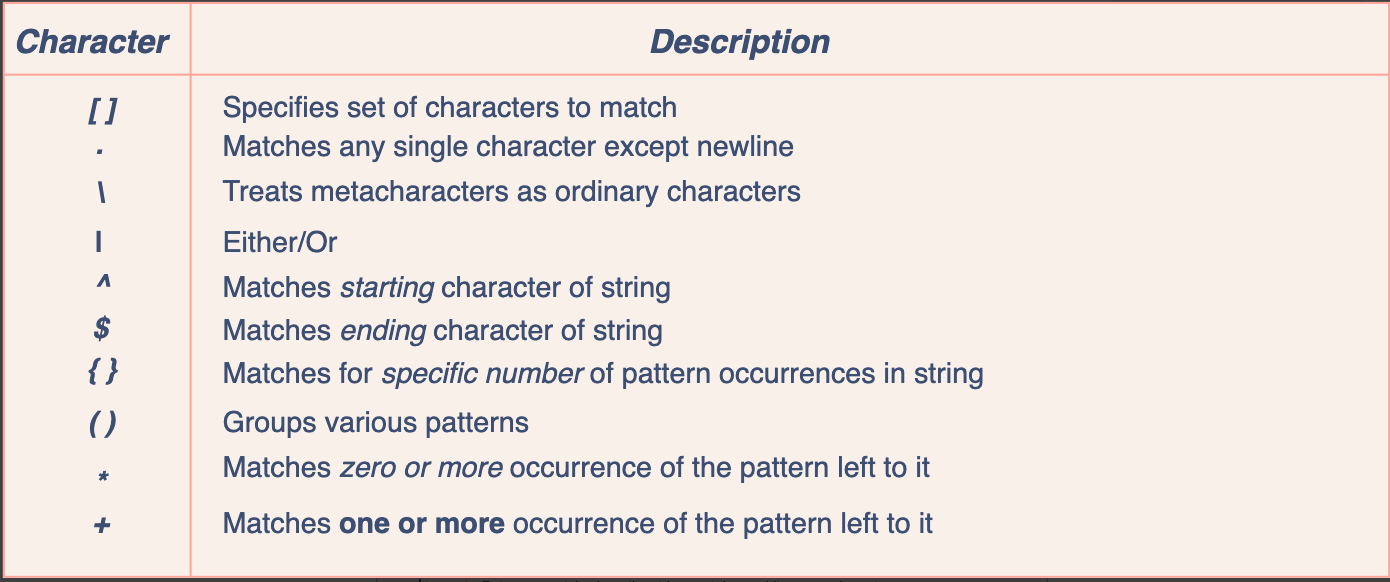

## Special Sequences

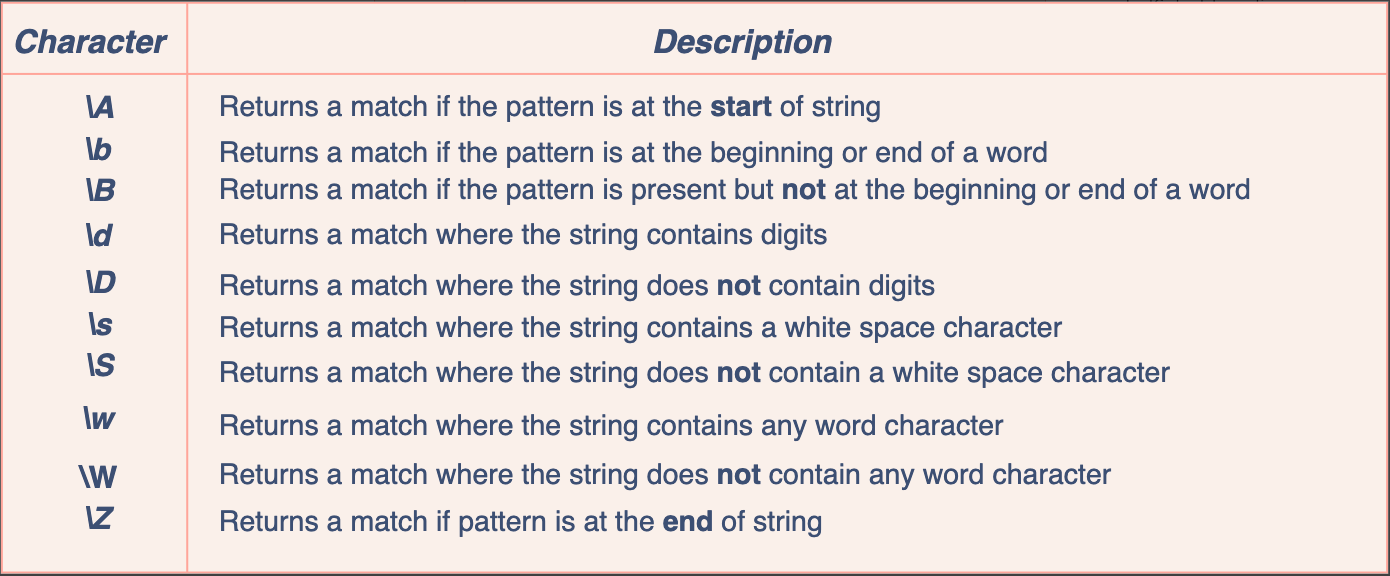

# RegEx functions
The re module provides users a variety of functions to search for a pattern in a particular string. Below are some of the most frequently used functions in detail:

### 1. re.findall()
The re.findall() function returns a list of strings containing all matches of the specified pattern.
The function takes as input the following:
* a character pattern
* the string from which to search  
```
string = "at what time?"
match = re.findall('at',string)
```
### 2. re.search()
The re.search() function returns a match object in case a match is found.  
The function takes as input the following:
* a character pattern
* the string from which to search  
```
string = "at what time?"
match = re.search('at',string)
```
### 3. re.split()
The re.split() function splits the string at every occurrence of the sub-string and returns a list of strings which have been split.  
The function takes as input the following:
* a character pattern
* the string from which to search  
```
string = "at what time?"
match = re.split('a',string)
```
### 4. re.sub()
The re.sub() function is used to replace occurrences of a particular sub-string with another sub-string.
This function takes as input the following:
* The sub-string to replace
* The sub-string to replace with
* The actual string
```
string = "at what time?"
match = re.sub("\s","!!!",string)
```

# Clean using RegEx

## Remove Links Replace with Displayed Text

# <center>```\[```    ```(.+)```    ```\]```</center>

|01 |02 |03 |04 |05 |06 |
|:-:|:-:|:-:|:-:|:-:|:-:|
|literal_Bracket|open_Group1|anything|1_or_more_times|close_Group1|literal_Bracket|
|\\ [           |(          |.       |+              |)           |\\]            |

# <center>```\(```    ```.```    ```+```    ```\)```</center>
|07 |08 |09 |10 |
|:-:|:-:|:-:|:-:|
|literal_Parenthesis|anything|1_or_more_times|literal_Parenthesis|
|\(                 |.       |+              |\)                 |


In [24]:
# Test text
text = """
        <html>Pull this data out</html><html><body><h1 align="center">
        <a href="https://spacevim.org/cn/">
        <img alt="SpaceVim" src="https://spacevim.org/logo.png" width="600"/>
        </a>
        </h1>
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [@kenney](http://opengameart.org/users/kenney)
        """

In [25]:
# Remove Links in parenthesis () following text in brackets [] then Replace Displayed Text from group 1 in brackets
stripped_links = re.sub(r"\[(.+)\]\(.+\)", r"\1", text)

In [26]:
# Take a look
stripped_links

'\n        <html>Pull this data out</html><html><body><h1 align="center">\n        <a href="https://spacevim.org/cn/">\n        <img alt="SpaceVim" src="https://spacevim.org/logo.png" width="600"/>\n        </a>\n        </h1>\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        @kenney\n        '

In [27]:
# Remove line breaks \n
stripped_line_break = stripped_links.replace("\n", '')
stripped_line_break

'        <html>Pull this data out</html><html><body><h1 align="center">        <a href="https://spacevim.org/cn/">        <img alt="SpaceVim" src="https://spacevim.org/logo.png" width="600"/>        </a>        </h1>        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        @kenney        '

## Remove HTML tags

In [28]:
# Import Module
from bs4 import BeautifulSoup
import requests
 
# Website URL
URL = 'https://www.geeksforgeeks.org/data-structures/'
 
# Page content from Website URL
page = requests.get(URL)
 
# Function to remove tags
def remove_tags(html):
 
    # parse html content
    soup = BeautifulSoup(html, "html.parser")
 
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
 
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)
 
 
# Print the extracted data
#print(remove_tags(page.content))

# EXPLORE

### list Variable
js_lem, cs_lem, jv_lem, py_lem,  
js_clean, cs_clean, jv_clean, py_clean

In [29]:
# word count
len(js_lem), len(cs_lem), len(jv_lem), len(py_lem)

(5244, 7452, 1412, 6073)

In [30]:
# word count
len(js_clean), len(cs_clean), len(jv_clean), len(py_clean)

(5244, 7452, 1412, 6073)

In [31]:
# Show percent of whole by language
train.language.value_counts(normalize=True)

JavaScript    0.352697
Python        0.319502
C#            0.215768
Java          0.112033
Name: language, dtype: float64

In [32]:
# JavaScript average Readme word count
train.language.value_counts(normalize=True)[0]*len(js_lem)

1849.5435684647305

In [33]:
# Python average Readme word count
train.language.value_counts(normalize=True)[1]*len(py_lem)

1940.3360995850621

In [34]:
# C# average Readme word count
train.language.value_counts(normalize=True)[2]*len(cs_lem)

1607.9004149377595

In [35]:
# Java average Readme word count
train.language.value_counts(normalize=True)[3]*len(jv_lem)

158.1908713692946

In [36]:
# Create frequency Series for lem
js_lem_freq = pd.Series(js_lem).value_counts()
cs_lem_freq = pd.Series(cs_lem).value_counts()
jv_lem_freq = pd.Series(jv_lem).value_counts()
py_lem_freq = pd.Series(py_lem).value_counts()
all_lem_freq = pd.Series(all_lem).value_counts()

# Create frequency Series for clean
js_clean_freq = pd.Series(js_clean).value_counts()
cs_clean_freq = pd.Series(cs_clean).value_counts()
jv_clean_freq = pd.Series(jv_clean).value_counts()
py_clean_freq = pd.Series(py_clean).value_counts()
all_clean_freq = pd.Series(all_clean).value_counts()

In [37]:
# Display lemmatized word count frequency by language
lem_word_counts = pd.concat([js_lem_freq, cs_lem_freq, jv_lem_freq, py_lem_freq, all_lem_freq], 
                            axis=1).fillna(0).astype(int)
lem_word_counts.columns = ['JavaScript','C#','Java', 'Python', 'All']
lem_word_counts.head()

,JavaScript,C#,Java,Python,All
fixed,82,72,1,2,157
x,50,3,0,4,57
use,41,38,16,27,122
software,40,37,3,16,96
v,33,86,3,1,123


In [38]:
# Display clean word count frequency by language
clean_word_counts = pd.concat([js_clean_freq, cs_clean_freq, jv_clean_freq, py_clean_freq, all_clean_freq], 
                            axis=1).fillna(0).astype(int)
clean_word_counts.columns = ['JavaScript','C#','Java', 'Python', 'All']
clean_word_counts.head()

,JavaScript,C#,Java,Python,All
fixed,82,72,1,2,157
x,50,3,0,4,57
use,41,38,16,27,122
software,40,37,3,16,96
v,33,81,2,1,117


In [39]:
# sort lem by 'all'
lem_word_counts.sort_values('All', ascending=False).head(10)

,JavaScript,C#,Java,Python,All
&#9;,7,528,0,56,591
fixed,82,72,1,2,157
part,8,117,0,3,128
v,33,86,3,1,123
use,41,38,16,27,122
project,24,24,10,42,100
software,40,37,3,16,96
file,11,27,9,47,94
feature,14,48,8,24,94
code,21,24,7,35,87


In [40]:
# sort by one language
lem_word_counts.sort_values(['JavaScript'], ascending=False).head(10)

,JavaScript,C#,Java,Python,All
fixed,82,72,1,2,157
x,50,3,0,4,57
use,41,38,16,27,122
software,40,37,3,16,96
v,33,86,3,1,123
tab,33,4,0,0,37
new,31,11,3,12,57
system,30,9,12,3,54
bug,30,12,0,2,44
create,29,2,0,24,55


In [41]:
# sort by one language
lem_word_counts.sort_values(['C#'], ascending=False).head(10)

,JavaScript,C#,Java,Python,All
&#9;,7,528,0,56,591
part,8,117,0,3,128
v,33,86,3,1,123
fix,5,80,0,2,87
fixed,82,72,1,2,157
issue,7,52,4,11,74
drag,1,51,0,0,52
ksp,0,48,0,0,48
feature,14,48,8,24,94
stiffening,0,44,0,0,44


In [42]:
# sort by one language
lem_word_counts.sort_values(['Java'], ascending=False).head(10)

,JavaScript,C#,Java,Python,All
planet,4,5,19,3,31
license,20,17,17,20,74
use,41,38,16,27,122
server,11,0,13,3,27
system,30,9,12,3,54
support,14,15,11,10,50
project,24,24,10,42,100
file,11,27,9,47,94
data,9,10,9,40,68
player,0,1,9,0,10


In [43]:
# sort by one language
lem_word_counts.sort_values(['Python'], ascending=False).head(10)

,JavaScript,C#,Java,Python,All
python,1,0,1,84,86
&#9;,7,528,0,56,591
image,5,1,0,54,60
codeblock,0,0,0,51,51
file,11,27,9,47,94
subnet,0,0,0,45,45
install,17,8,1,43,69
project,24,24,10,42,100
data,9,10,9,40,68
model,0,15,3,36,54


<AxesSubplot:>

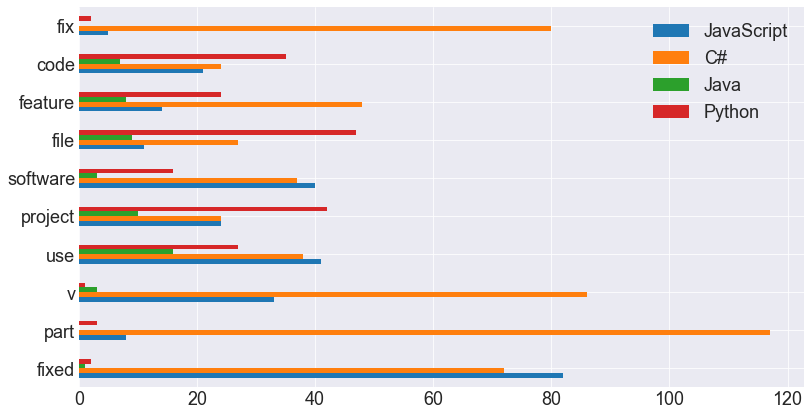

In [44]:
# show highest over 'All' word count campared by language
plt.rc('font', size=18)
lem_word_counts.sort_values('All', 
                            ascending=False)[['JavaScript',
                                              'C#',
                                              'Java', 
                                              'Python']][1:11].plot.barh()

In [45]:
# show highest over 'All' word percentage campared by language
lem_word_counts.sort_values('All', ascending=False)\
 .head(10)\
 .apply(lambda row: row/row['All'], axis = 1)

,JavaScript,C#,Java,Python,All
&#9;,0.011844,0.893401,0.000000,0.094755,1.0
fixed,0.522293,0.458599,0.006369,0.012739,1.0
part,0.062500,0.914062,0.000000,0.023438,1.0
v,0.268293,0.699187,0.024390,0.008130,1.0
use,0.336066,0.311475,0.131148,0.221311,1.0
project,0.240000,0.240000,0.100000,0.420000,1.0
software,0.416667,0.385417,0.031250,0.166667,1.0
file,0.117021,0.287234,0.095745,0.500000,1.0
feature,0.148936,0.510638,0.085106,0.255319,1.0
code,0.241379,0.275862,0.080460,0.402299,1.0


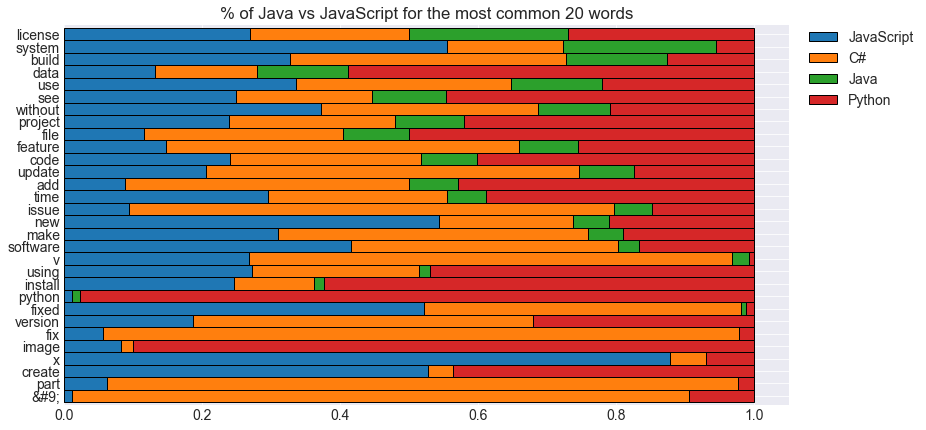

In [86]:
# visually compare the four languages by the top 20 most frequent words
#plt.figure(figsize=(9, 9))
plt.rc('font', size=14)

(lem_word_counts.sort_values('All', ascending=False)
 .head(30)
 .apply(lambda row: row/row['All'], axis = 1)
 .drop(columns = 'All')
 .sort_values(by = 'Java')
 .plot.barh(stacked = True, width = 1, ec = 'k', legend=False)
)
plt.title('% of Java vs JavaScript for the most common 20 words')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

**Be Careful!** Make sure you are making bigrams out of *words*.

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

In [47]:
# Display Bi-Gram using ngram code
list(nltk.ngrams(all_lem, 2))

[('build', 'status'),
 ('status', 'designspace'),
 ('designspace', 'designspace'),
 ('designspace', 'prototype'),
 ('prototype', 'design'),
 ('design', 'tool'),
 ('tool', 'htc'),
 ('htc', 'vive'),
 ('vive', 'urban'),
 ('urban', 'designer'),
 ('designer', 'architect'),
 ('architect', 'first'),
 ('first', 'developed'),
 ('developed', 'aec'),
 ('aec', 'hackathon'),
 ('hackathon', 'london'),
 ('london', 'tool'),
 ('tool', 'demonstrates'),
 ('demonstrates', 'could'),
 ('could', 'load'),
 ('load', 'position'),
 ('position', 'reference'),
 ('reference', 'image'),
 ('image', 'work'),
 ('work', 'scale'),
 ('scale', 'add'),
 ('add', 'simple'),
 ('simple', 'block'),
 ('block', 'volume'),
 ('volume', 'sketch'),
 ('sketch', 'directly'),
 ('directly', 'model'),
 ('model', 'note'),
 ('note', 'current'),
 ('current', 'version'),
 ('version', 'still'),
 ('still', 'quite'),
 ('quite', 'bug'),
 ('bug', 'ui'),
 ('ui', 'model'),
 ('model', 'interaction'),
 ('interaction', 'usage'),
 ('usage', 'repo'),
 ('r

<AxesSubplot:>

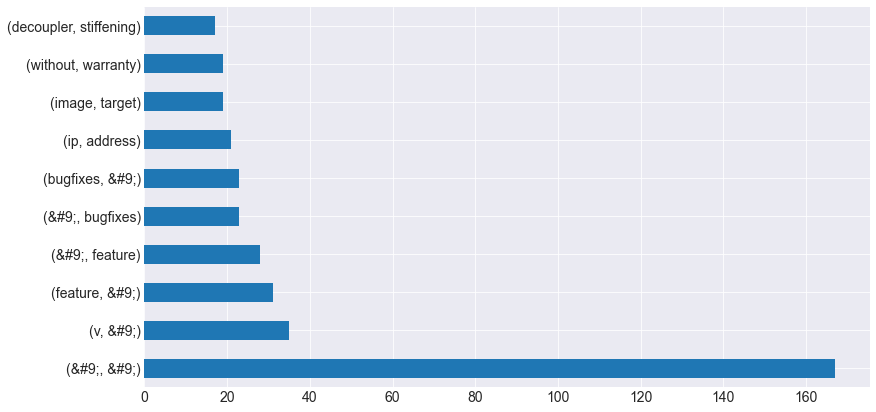

In [48]:
# Display top 10 bigram pairs for JavaScript lemmatized
pd.Series(nltk.bigrams(all_lem)
         ).value_counts().head(10).plot.barh()

In [81]:
# Create Bi-Grams for each language
js_2_gram = list(nltk.ngrams(js_lem, 2))
cs_2_gram = list(nltk.ngrams(cs_lem, 2))
jv_2_gram = list(nltk.ngrams(jv_lem, 2))
py_2_gram = list(nltk.ngrams(py_lem, 2))
all_2_gram = list(nltk.ngrams(all_lem, 2))

In [82]:
# Display Bi-Gram using ngram code
all_2_gram

[('build', 'status'),
 ('status', 'designspace'),
 ('designspace', 'designspace'),
 ('designspace', 'prototype'),
 ('prototype', 'design'),
 ('design', 'tool'),
 ('tool', 'htc'),
 ('htc', 'vive'),
 ('vive', 'urban'),
 ('urban', 'designer'),
 ('designer', 'architect'),
 ('architect', 'first'),
 ('first', 'developed'),
 ('developed', 'aec'),
 ('aec', 'hackathon'),
 ('hackathon', 'london'),
 ('london', 'tool'),
 ('tool', 'demonstrates'),
 ('demonstrates', 'could'),
 ('could', 'load'),
 ('load', 'position'),
 ('position', 'reference'),
 ('reference', 'image'),
 ('image', 'work'),
 ('work', 'scale'),
 ('scale', 'add'),
 ('add', 'simple'),
 ('simple', 'block'),
 ('block', 'volume'),
 ('volume', 'sketch'),
 ('sketch', 'directly'),
 ('directly', 'model'),
 ('model', 'note'),
 ('note', 'current'),
 ('current', 'version'),
 ('version', 'still'),
 ('still', 'quite'),
 ('quite', 'bug'),
 ('bug', 'ui'),
 ('ui', 'model'),
 ('model', 'interaction'),
 ('interaction', 'usage'),
 ('usage', 'repo'),
 ('r

<AxesSubplot:>

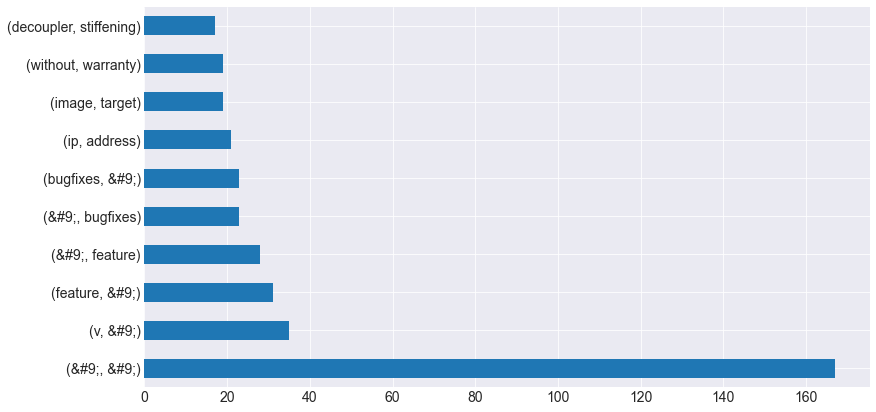

In [83]:
# Display top 10 bigram pairs for JavaScript lemmatized
pd.Series(all_2_gram).value_counts().head(10).plot.barh()

<function matplotlib.pyplot.show(close=None, block=None)>

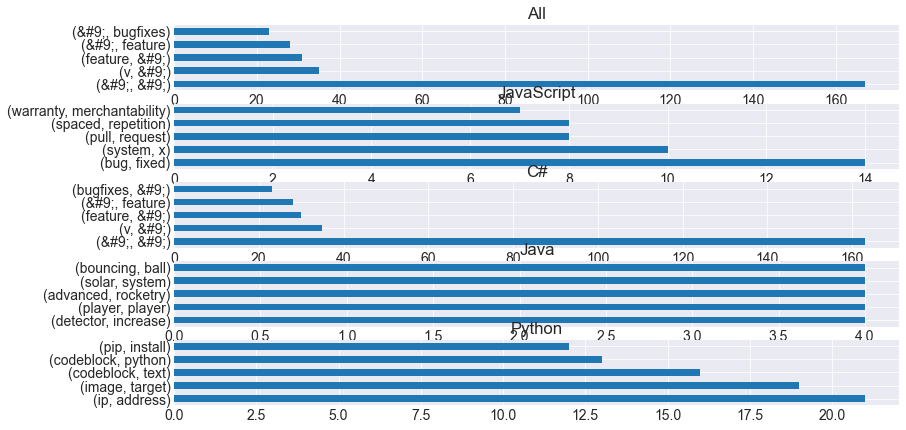

In [85]:
# Display top 5 bigram pairs for JavaScript lemmatized

plt.subplot(5,1,1)
pd.Series(all_2_gram).value_counts().head(5).plot.barh()
plt.title('All')

plt.subplot(5,1,2)
pd.Series(js_2_gram).value_counts().head(5).plot.barh()
plt.title('JavaScript')

plt.subplot(5,1,3)
pd.Series(cs_2_gram).value_counts().head(5).plot.barh()
plt.title('C#')

plt.subplot(5,1,4)
pd.Series(jv_2_gram).value_counts().head(5).plot.barh()
plt.title('Java')

plt.subplot(5,1,5)
pd.Series(py_2_gram).value_counts().head(5).plot.barh()
plt.title('Python')

plt.show

In [84]:
# Create N-Grams of 3N for each language
js_3_gram = list(nltk.ngrams(js_lem, 3))
cs_3_gram = list(nltk.ngrams(cs_lem, 3))
jv_3_gram = list(nltk.ngrams(jv_lem, 3))
py_3_gram = list(nltk.ngrams(py_lem, 3))
all_3_gram = list(nltk.ngrams(all_lem, 3))

In [52]:
all_3_gram

[('build', 'status', 'designspace'),
 ('status', 'designspace', 'designspace'),
 ('designspace', 'designspace', 'prototype'),
 ('designspace', 'prototype', 'design'),
 ('prototype', 'design', 'tool'),
 ('design', 'tool', 'htc'),
 ('tool', 'htc', 'vive'),
 ('htc', 'vive', 'urban'),
 ('vive', 'urban', 'designer'),
 ('urban', 'designer', 'architect'),
 ('designer', 'architect', 'first'),
 ('architect', 'first', 'developed'),
 ('first', 'developed', 'aec'),
 ('developed', 'aec', 'hackathon'),
 ('aec', 'hackathon', 'london'),
 ('hackathon', 'london', 'tool'),
 ('london', 'tool', 'demonstrates'),
 ('tool', 'demonstrates', 'could'),
 ('demonstrates', 'could', 'load'),
 ('could', 'load', 'position'),
 ('load', 'position', 'reference'),
 ('position', 'reference', 'image'),
 ('reference', 'image', 'work'),
 ('image', 'work', 'scale'),
 ('work', 'scale', 'add'),
 ('scale', 'add', 'simple'),
 ('add', 'simple', 'block'),
 ('simple', 'block', 'volume'),
 ('block', 'volume', 'sketch'),
 ('volume', 's

<AxesSubplot:>

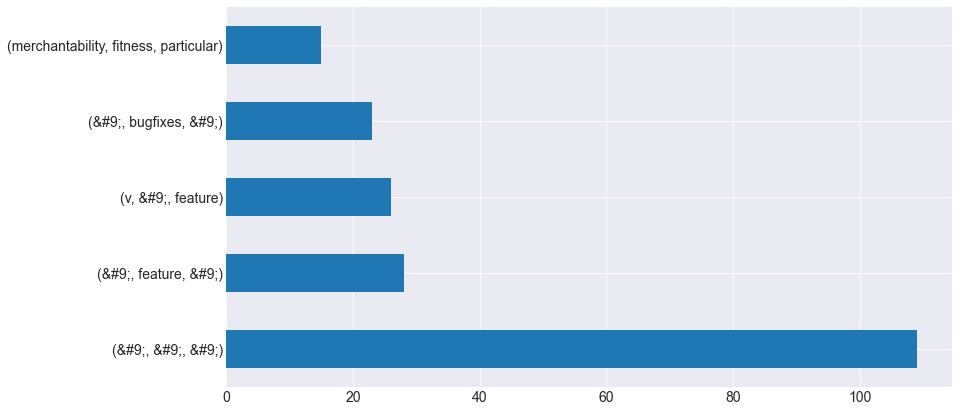

In [53]:
# Display top 5 bigram pairs for JavaScript lemmatized
pd.Series(all_3_gram).value_counts().head(5).plot.barh()

<function matplotlib.pyplot.show(close=None, block=None)>

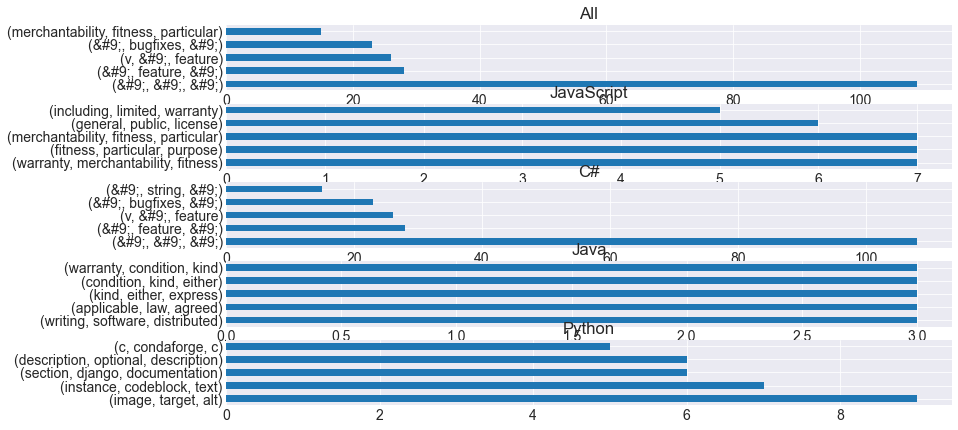

In [54]:
# Display top 5 bigram pairs for JavaScript lemmatized

plt.subplot(5,1,1)
pd.Series(all_3_gram).value_counts().head(5).plot.barh()
plt.title('All')

plt.subplot(5,1,2)
pd.Series(js_3_gram).value_counts().head(5).plot.barh()
plt.title('JavaScript')

plt.subplot(5,1,3)
pd.Series(cs_3_gram).value_counts().head(5).plot.barh()
plt.title('C#')

plt.subplot(5,1,4)
pd.Series(jv_3_gram).value_counts().head(5).plot.barh()
plt.title('Java')

plt.subplot(5,1,5)
pd.Series(py_3_gram).value_counts().head(5).plot.barh()
plt.title('Python')

plt.show

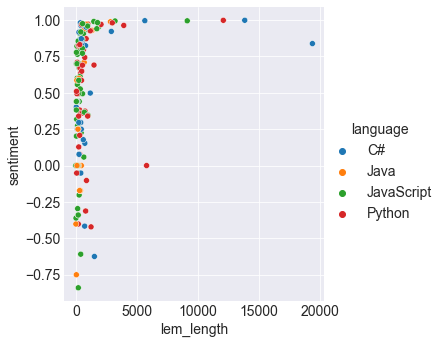

In [55]:
# plot message_length vs sentiment and hue by language
sns.relplot(data = train, x = 'lem_length', 
            y = 'sentiment', hue = 'language')

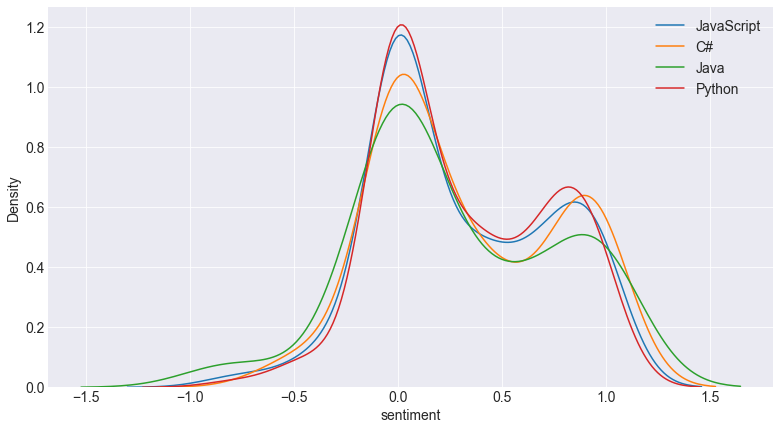

In [56]:
# is the distribution for sentiment different for any of the languages
sns.kdeplot(df[df.language == 'JavaScript'].sentiment, label = 'JavaScript')
sns.kdeplot(df[df.language == 'C#'].sentiment, label = 'C#')
sns.kdeplot(df[df.language == 'Java'].sentiment, label = 'Java')
sns.kdeplot(df[df.language == 'Python'].sentiment, label = 'Python')
plt.legend(['JavaScript', 'C#', 'Java', 'Python'])

<AxesSubplot:xlabel='lem_length', ylabel='sentiment'>

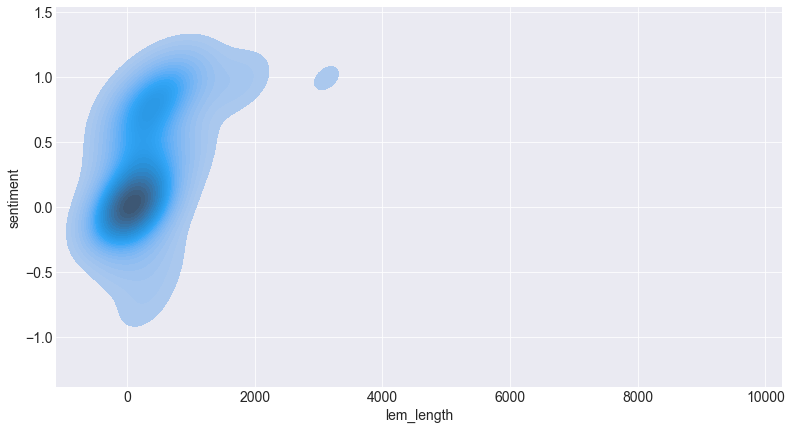

In [57]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    df[df.language == 'JavaScript'].lem_length,
    df[df.language == 'JavaScript'].sentiment, 
    levels = 30, shade = True );
sns.kdeplot(
            levels = 30, shade = True, alpha = 0.5 )

<AxesSubplot:xlabel='lem_length', ylabel='sentiment'>

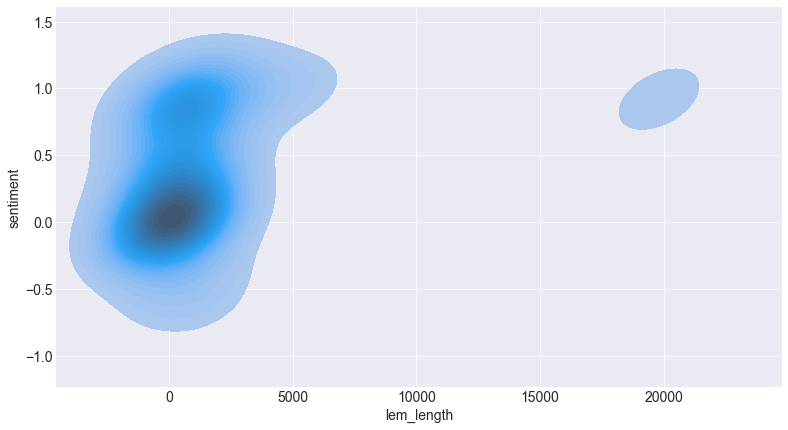

In [58]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    df[df.language == 'C#'].lem_length,
    df[df.language == 'C#'].sentiment, 
    levels = 30, shade = True );
sns.kdeplot(
            levels = 30, shade = True, alpha = 0.5 )

<AxesSubplot:xlabel='lem_length', ylabel='sentiment'>

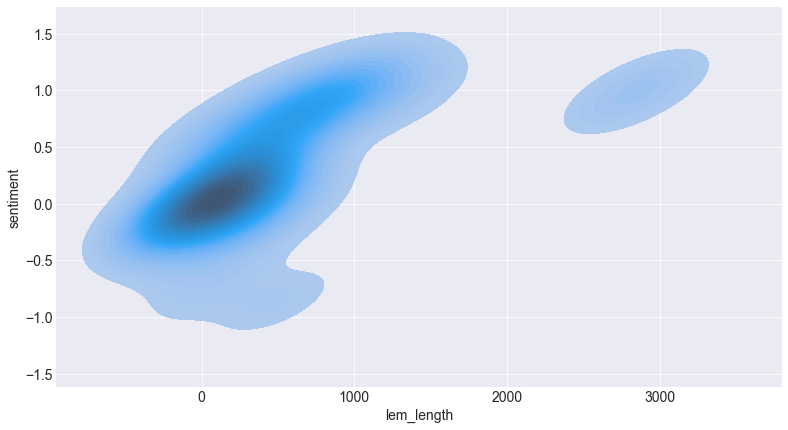

In [59]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    df[df.language == 'Java'].lem_length,
    df[df.language == 'Java'].sentiment, 
    levels = 30, shade = True );
sns.kdeplot(
            levels = 30, shade = True, alpha = 0.5 )

<AxesSubplot:xlabel='lem_length', ylabel='sentiment'>

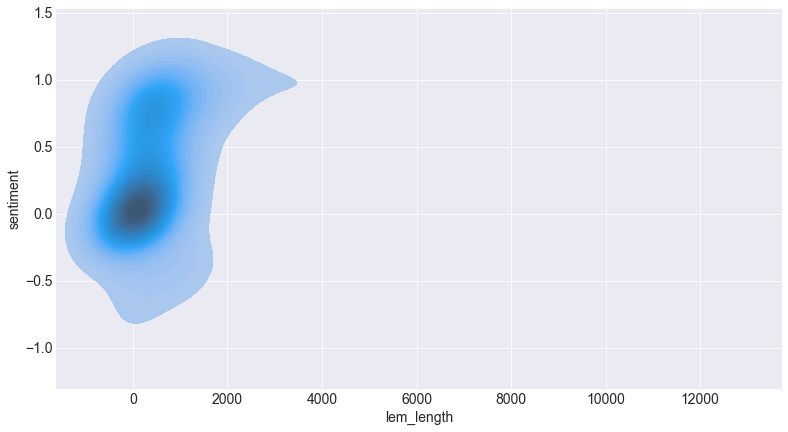

In [60]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    df[df.language == 'Python'].lem_length,
    df[df.language == 'Python'].sentiment, 
    levels = 30, shade = True );
sns.kdeplot(
            levels = 30, shade = True, alpha = 0.5 )

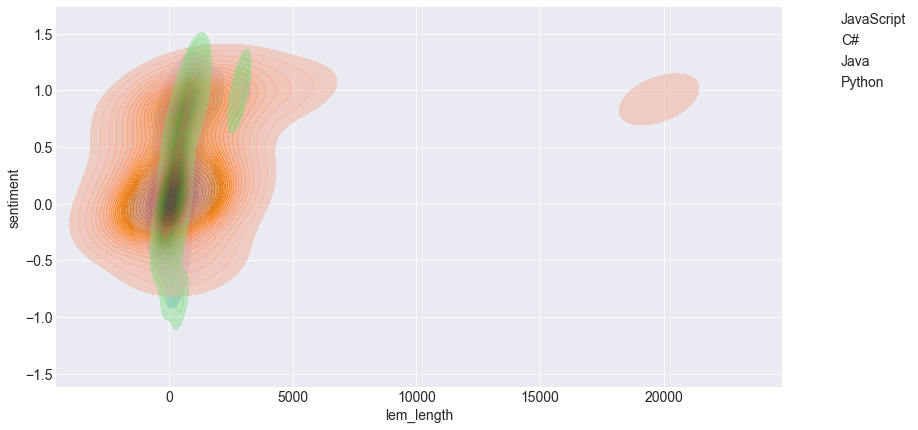

In [61]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    df[df.language == 'JavaScript'].lem_length,
    df[df.language == 'JavaScript'].sentiment, 
    levels = 30, shade = True, alpha=0.80, label = 'JavaScript'); 
    #palette=["rocket"], as_cmap=True, label='JavaScript');
sns.kdeplot(
    df[df.language == 'C#'].lem_length,
    df[df.language == 'C#'].sentiment, 
    levels = 30, shade = True, alpha=0.60, label = 'C#'); 
    #palette=["mako"], as_cmap=True, label='C#');
sns.kdeplot(
    df[df.language == 'Java'].lem_length,
    df[df.language == 'Java'].sentiment, 
    levels = 30, shade = True, alpha=0.40, label = 'Java'); 
    #palette=["flare"], as_cmap=True, label='Java');
sns.kdeplot(
    df[df.language == 'Python'].lem_length,
    df[df.language == 'Python'].sentiment, 
    levels = 30, shade = True, alpha=0.20, label = 'Python') 
    #palette=["crest"], as_cmap=True, label='Python')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


# STATISTICAL TESTING

**Set Hypothesis**  

* One Tail (```<= | >```) or Two Tails (```== | !=```)?
    * two_tail (feature_1, feature_2)  


* One Sample or Two Samples?    
    * two_sample (feature_1, feature_2)  


* Continuous or Discreat?  
    * Discreat (feature_1) vs Discreat (feature_2) = **$Chi^2$**
        * T-Test = ```Discreat``` vs ```Continuous```  
        * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
        * $Chi^2$ = ```Discreat``` vs ```Discreat```  


* $𝐻_0$: The opposite of what I am trying to prove  
    * $H_{0}$: feature_1 **is NOT** ```dependent``` on feature_2  
    * ```feature_1``` != ```feature_2```  


* $𝐻_𝑎$: What am I trying to prove  
    * $H_{a}$: feature_1 **is** ```dependent``` on feature_2  
    * ```feature_1``` == ```feature_2```

# Q1. Is there a significant difference in Lemmatized Length across all four languages? 

## Hypothesis

two_tail, two_sample

* Continuous or Discreat?  
    * Discreat (feature_1) vs Discreat (feature_2) = **$Chi^2$**
        * T-Test = ```Discreat``` vs ```Continuous```  
        * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
        * $Chi^2$ = ```Discreat``` vs ```Discreat```  


* $𝐻_0$: The opposite of what I am trying to prove  
    * $H_{0}$: Lemmatized Length **is NOT** ```significantly different``` across languages  
    * ```sentiment``` != ```language```  


* $𝐻_𝑎$: What am I trying to prove  
    * $H_{a}$: Lemmatized Length **is** ```significantly different``` across languages  
    * ```sentiment``` == ```language```  

## Visualization

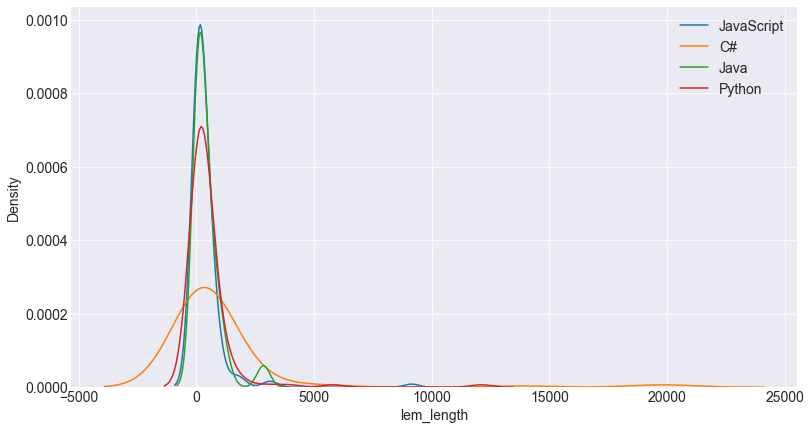

In [62]:
# is the distribution for sentiment different for any of the languages
sns.kdeplot(df[df.language == 'JavaScript'].lem_length, label = 'JavaScript')
sns.kdeplot(df[df.language == 'C#'].lem_length, label = 'C#')
sns.kdeplot(df[df.language == 'Java'].lem_length, label = 'Java')
sns.kdeplot(df[df.language == 'Python'].lem_length, label = 'Python')
plt.legend(['JavaScript', 'C#', 'Java', 'Python'])

## Statistical Test of Hypothesis

<div class="alert alert-warning">

# ANOVA $latex y_i = b_0+b_1X_{1,i} +…+b_{j-1,i} + e_i&s=2$
* ANOVA is a means of comparing the ratio of systematic variance to unsystematic variance in an experimental study. 
* Variance in the ANOVA is partitioned into total variance, variance due to groups, and variance due to individual differences.
* The ratio obtained when doing this comparison is known as the F-ratio. 
* A one-way ANOVA can be seen as a regression model with a single categorical predictor. This predictor usually has two plus categories. A one-way ANOVA has a single factor with J levels. Each level corresponds to the groups in the independent measures design.

    
* As for all parametric tests the data need to be normally distributed (each group’s data should be roughly normally distributed) for the F-statistic to be reliable. 
* Each experimental condition should have roughly the same variance (i.e., homogeneity of variance), the observations (e.g., each group) should be independent, and the dependent variable should be measured on, at least,  an interval scale.

#### Assumptions:
As with all parametric tests also ANOVA has a number of assumptions. 
1. First of all, the groups have to be independent of each other. 
2. Second, the data needs to be normally distributed (within each group). 
3. Third, there have to be equal variances between all groups. 

Homogeneity of variances can be tested with [Bartlett’s and Levene’s test](https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/) in Python (e.g., using SciPy) and the normality assumption can be tested using the Shapiro-Wilks test or by examining the distribution. Note, if your data is skewed you can transform it using e.g. the [log transformation](https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/) in Python.



In [63]:
# Create Variables for lemmatized length and sentiment for each language

# JavaScript
js_lem_length = train[train.language == 'JavaScript'].lem_length
js_sentiment = train[train.language == 'JavaScript'].sentiment
# C#
cs_lem_length = train[train.language == 'C#'].lem_length
cs_sentiment = train[train.language == 'C#'].sentiment
# C#
jv_lem_length = train[train.language == 'Java'].lem_length
jv_sentiment = train[train.language == 'Java'].sentiment
# C#
py_lem_length = train[train.language == 'Python'].lem_length
py_sentiment = train[train.language == 'Python'].sentiment
# All
all_lem_length = train.lem_length
all_sentiment = train.sentiment

#### All Languages

In [64]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(js_lem_length, cs_lem_length, jv_lem_length, py_lem_length)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 1.351023097653396
p_val: 0.25853617336192186
------------------------------
Fail to reject the null hypothesis


#### JavaScript

In [65]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(js_lem_length, all_lem_length)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.7793702371653413
p_val: 0.37798834271666126
------------------------------
Fail to reject the null hypothesis


#### C#

In [66]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(cs_lem_length, all_lem_length)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 1.6706296795557867
p_val: 0.19719957036765667
------------------------------
Fail to reject the null hypothesis


#### Java

In [67]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(jv_lem_length, all_lem_length)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.41359584076055445
p_val: 0.5207040164275749
------------------------------
Fail to reject the null hypothesis


#### Python

In [68]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(py_lem_length, all_lem_length)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 6.064672754011404e-07
p_val: 0.9993791307980276
------------------------------
Fail to reject the null hypothesis


#### Java vs C#

In [69]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(jv_lem_length, cs_lem_length)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 1.101538988496262
p_val: 0.2972116233645561
------------------------------
Fail to reject the null hypothesis


<div class="alert alert-info">
    
# Q1
    
### NO
### The Lemmatized length **is NOT** ```significantly different``` across the four program languages.
    
    
### **There is no evidence to support that the Lemmatized length of each program language Readme file is significantly different and will have an impact in determinng the program language.**  
    
* Based on this statistical finding we believe that Lemmatized length would not be an integral feature and should not be included in any machine learning efforts going forward.

# Q2. Is there a significant difference in Sentiment across all four languages? 

## Hypothesis

two_tail, two_sample

* Continuous or Discreat?  
    * Discreat (feature_1) vs Discreat (feature_2) = **$Chi^2$**
        * T-Test = ```Discreat``` vs ```Continuous```  
        * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
        * $Chi^2$ = ```Discreat``` vs ```Discreat```  


* $𝐻_0$: The opposite of what I am trying to prove  
    * $H_{0}$: Sentiment **is NOT** ```significantly different``` across languages  
    * ```sentiment``` != ```language```  


* $𝐻_𝑎$: What am I trying to prove  
    * $H_{a}$: Sentiment **is** ```significantly different``` across languages  
    * ```sentiment``` == ```language```  

## Visualization

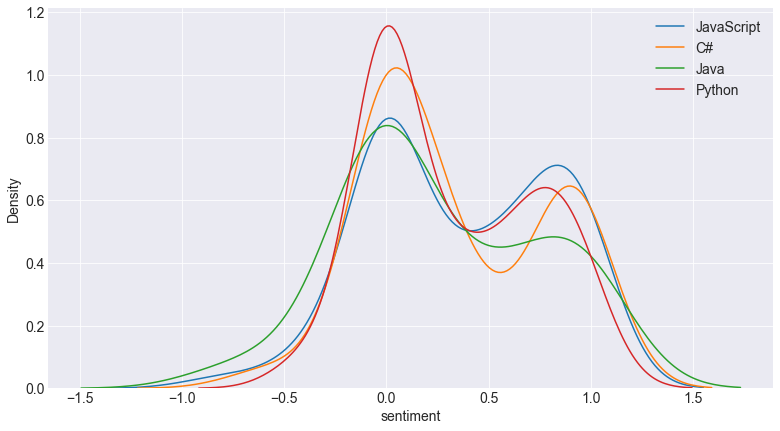

In [70]:
# is the distribution for sentiment different for any of the languages
sns.kdeplot(js_sentiment, label = 'JavaScript')
sns.kdeplot(cs_sentiment, label = 'C#')
sns.kdeplot(jv_sentiment, label = 'Java')
sns.kdeplot(py_sentiment, label = 'Python')
plt.legend(['JavaScript', 'C#', 'Java', 'Python'])

## Statistical Test of Hypothesis

<div class="alert alert-warning">

# ANOVA $latex y_i = b_0+b_1X_{1,i} +…+b_{j-1,i} + e_i&s=2$
* ANOVA is a means of comparing the ratio of systematic variance to unsystematic variance in an experimental study. 
* Variance in the ANOVA is partitioned into total variance, variance due to groups, and variance due to individual differences.
* The ratio obtained when doing this comparison is known as the F-ratio. 
* A one-way ANOVA can be seen as a regression model with a single categorical predictor. This predictor usually has two plus categories. A one-way ANOVA has a single factor with J levels. Each level corresponds to the groups in the independent measures design.

    
* As for all parametric tests the data need to be normally distributed (each group’s data should be roughly normally distributed) for the F-statistic to be reliable. 
* Each experimental condition should have roughly the same variance (i.e., homogeneity of variance), the observations (e.g., each group) should be independent, and the dependent variable should be measured on, at least,  an interval scale.

#### Assumptions:
As with all parametric tests also ANOVA has a number of assumptions. 
1. First of all, the groups have to be independent of each other. 
2. Second, the data needs to be normally distributed (within each group). 
3. Third, there have to be equal variances between all groups. 

Homogeneity of variances can be tested with [Bartlett’s and Levene’s test](https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/) in Python (e.g., using SciPy) and the normality assumption can be tested using the Shapiro-Wilks test or by examining the distribution. Note, if your data is skewed you can transform it using e.g. the [log transformation](https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/) in Python.



#### All Languages

In [71]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(js_sentiment, cs_sentiment, jv_sentiment, py_sentiment)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.4013359085711304
p_val: 0.7521678915596715
------------------------------
Fail to reject the null hypothesis


#### JavaScript

In [72]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(js_sentiment, all_sentiment)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.3180877744554637
p_val: 0.5731492704549837
------------------------------
Fail to reject the null hypothesis


#### C#

In [73]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(cs_sentiment, all_sentiment)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.032151752417445334
p_val: 0.8578197881176829
------------------------------
Fail to reject the null hypothesis


#### Java

In [74]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(jv_sentiment, all_sentiment)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.49280960623875164
p_val: 0.48329046264470377
------------------------------
Fail to reject the null hypothesis


#### Python

In [75]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(py_sentiment, all_sentiment)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.13680483089502335
p_val: 0.711726093445558
------------------------------
Fail to reject the null hypothesis


#### Java vs Python

In [76]:
import scipy.stats as stats
alpha = α = 0.05

## stats f_oneway functions takes the groups as input and returns ANOVA F and p value
## Leammatized Length
f_val, p_val = stats.f_oneway(jv_sentiment, py_sentiment)

print(f'f_val: {f_val}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

f_val: 0.19922614759583668
p_val: 0.6562923494068906
------------------------------
Fail to reject the null hypothesis


<div class="alert alert-info">
    
# Q2
    
### NO
### The Sentiment **is NOT** ```significantly different``` across the four program languages.
    
    
### **There is no evidence to support that the Sentiment of each program language Readme file is significantly different and will have an impact in determinng the program language.**  
    
* Based on this statistical finding we believe that Sentiment would not be an integral feature and should not be included in any machine learning efforts going forward.

<div class="alert alert-warning">



# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [77]:
r, p_val = stats.pearsonr(js_lem_length, js_sentiment)

print(f'    r: {r}')
print(f'p_val: {p_val}')
print('------------------------------')

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

    r: 0.38623978648484836
p_val: 0.0002612342838653436
------------------------------
Reject the null hypothesis
